In [1]:
%reload_ext autoreload
%autoreload 2

## Library

In [2]:
#from src.util import *
#from src.data import *
#from src.pmodel import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [3]:
import gc
import os
import pickle
import random
import re
import sklearn.metrics
import sklearn.model_selection
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict
from tqdm import tqdm, tqdm_notebook

KAGGLE_RUN = (not os.path.exists('/opt/conda/home/.history'))
if KAGGLE_RUN: print('Kaggle run')

pd.options.display.float_format = '{:.6f}'.format


def tf_seed_everything(seed):
    import tensorflow as tf
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)

def f1_curve(target, preds, t_min=0.01, t_max=0.99, steps=99):
    curve = {}
    for t in np.linspace(t_min, t_max, steps):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            curve[t] = sklearn.metrics.f1_score(target, preds >= t)
    return pd.Series(curve).sort_index()


Kaggle run


In [4]:
import functools
import multiprocessing
import os
import pickle
import random
import re
import sklearn.preprocessing
import unicodedata

import numpy as np
import pandas as pd


class QuoraData:
    def __init__(self):
        self.paths = {
            'glove': '../input/embeddings/glove.840B.300d/glove.840B.300d.txt',
            'news': '../input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin',
            'paragram': '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt',
            'wiki': '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec',
        }

    def glove(self): return QuoraEmbedding(self.paths['glove'])
    def news(self): return QuoraEmbedding(self.paths['news'])
    def paragram(self): return QuoraEmbedding(self.paths['paragram'])
    def wiki(self): return QuoraEmbedding(self.paths['wiki'])

    def convert_start(self, embeddings):
        """Start conversion of specified embedding names to .npy format in background."""

        self.convert_pids = []

        for name in embeddings:
            path = self.paths[name]
            if path.endswith('.npy'): continue
            if os.path.exists(path + '.npy'): continue
            if os.path.exists(name + '.npy'): continue
            if KAGGLE_RUN:
                out_path = name + '.npy'
            else:
                out_path = path + '.npy'
            print(f'Converting {path} -> {out_path}', flush=True)
            pid = os.fork()
            if pid == 0:
                emb = QuoraEmbedding(path)
                emb.save_npy(out_path)
                os._exit(0)

            self.convert_pids.append(pid)
            self.paths[name] = out_path

    def convert_wait(self):
        """Wait for .npy conversion to finish."""
        for pid in self.convert_pids:
            try:
                os.waitpid(pid, 0)
            except:
                pass

    def read_train(self):
        return pd.read_csv('../input/train.csv')

    def read_test(self):
        return pd.read_csv('../input/test.csv')

    def read_input(self):
        return pd.concat([self.read_train(), self.read_test()], axis=0, copy=False, sort=False, ignore_index=True)


class QuoraEmbedding:
    """Quora's pretrained embeddings loader."""

    def __init__(self, filename, vectors=None, vocab=None):
        self.filename = filename
        if vectors is None:
            vectors, vocab = self._read(filename)
        self.vectors = vectors
        self.index2word = vocab
        self.name = re.findall('^\w+', os.path.basename(filename))[0]
        self.shape = self.vectors.shape
        self.num_words, self.dim = self.shape
        assert len(self.index2word) == self.num_words
        # On collisions, pick the earliest (more frequent) vector's index
        self.word2index = { self.index2word[i]: i for i in reversed(range(self.num_words)) }
        self.lword2index = { self.index2word[i].lower(): i for i in reversed(range(self.num_words)) }

    def __repr__(self):
        return f'QuoraEmbedding({self.name}, {self.shape[0]}x{self.shape[1]}, {self.vectors.nbytes/(1024**3):.1f}GiB)'

    def lookup(self, word, lower=False):
        if lower:
            idx = self.lword2index.get(word.lower(), -1)
        else:
            idx = self.word2index.get(word, -1)
        return self.vectors[idx] if idx != -1 else None

    @functools.lru_cache(1)
    def mean(self): return self.vectors.mean()

    @functools.lru_cache(1)
    def std(self): return self.vectors.std()

    def save_npy(self, filename):
        assert filename.endswith('.npy')
        np.save(filename, self.vectors)
        with open(filename[:-4] + '.vocab', 'wb') as fp:
            pickle.dump(self.index2word, fp)

    @classmethod
    def _read(cls, filename):
        """Reads file, returns (weights matrix, vocabulary list)."""
        if filename.endswith('.npy'):
            return cls._read_npy(filename)
        elif os.path.exists(filename + '.npy'):
            return cls._read_npy(filename + '.npy')
        elif os.path.exists(re.sub('[.]\w+$', '.npy', filename)):
            return cls._read_npy(re.sub('[.]\w+$', '.npy', filename))
        elif filename.endswith('.bin'):
            return cls._read_bin(filename)
        else:
            return cls._read_txt(filename)

    @classmethod
    def _read_npy(cls, filename):
        assert filename.endswith('.npy')
        vectors = np.load(filename, 'r')
        with open(filename[:-4] + '.vocab', 'rb') as fp:
            vocab = pickle.load(fp)
        return vectors, vocab

    @classmethod
    def _read_txt(cls, filename):
        vectors = []
        vocab = []
        dim = -1

        for line_num, line in enumerate(open(filename, 'rb')):
            try:
                line = line.decode('utf-8')
            except:
                line = line.decode('latin_1')
                print(f'Bad word on line {line_num+1}: {line[:20]}...')

            word, line = line.split(' ', maxsplit=1)
            vec = np.fromstring(line, np.float32, count=dim, sep=' ')
            if len(vec) == 1 and len(vectors) == 0:
                dim = int(vec[0])
                continue

            if dim != -1 and dim != len(vec):
                raise Exception(f'Mismatching vector lengths: {dim} vs {len(vec)}')
            dim = len(vec)

            vectors.append(vec)
            vocab.append(word)

        vectors = np.stack(vectors)
        vocab = '\n'.join(vocab).split('\n')
        return vectors, vocab

    @classmethod
    def _read_bin(cls, filename):
        from gensim.models import KeyedVectors
        kv = KeyedVectors.load_word2vec_format(filename, binary=True)
        return kv.vectors, kv.index2word


class QuoraPreprocessor:
    """Preprocesses raw text before tokenization."""

    punct = r"""-!"#$%^&*+,.'\\\[\]()/:;?@_{}|~`’:”“=…<>√£°₹×€—？÷र™−•¿→®一，¹²³⁴₂∞℅∫∆øΔ∈½·≠（）。»«ʻくº—"""
    punct += "\xa0"

    specialLR = '|'.join([re.sub('([.()])', r'\\\1', s) for s in r"""
        's 'm 'd 'll 're 've n't 'em o'clock
        i.e. e.g. vs. U.S. U.K. [A-Za-z]. a.m. p.m.
        e-mail t-shirt
        : :) :D :-) :) ;) :-) =) ;-)
        [0-9]+,[0-9]{3}
    """.split()])

    specialL = '|'.join([re.sub('([.()])', r'\\\1', s) for s in r"""
        [A-Za-z]. Mr. Mrs. Dr. a.m. p.m.
    """.split()])

    special = '|'.join([s for s in r"""
        \.{3,5}  [?!]{1,3}
    """.split()])

    re_ws = re.compile(r'[\t\n ]+')
    re_apos = re.compile(r"""['’`‘´`′′]""")
    re_contractions = re.compile(r"(\w)('s|'m|'d|'ll|'re|'ve|n't|'em)( |[%s])" % punct, re.UNICODE | re.I)
    re_special = re.compile(fr"(((?<= )({specialLR})(?= ))|((?<= )({specialL}))|{special}|[{punct}])",
                            re.UNICODE | re.I)

    tests = [
        ("Don`t y'all thinkin' it's, like, we're getting... a\xa0little ``too'' late?!?!",
         "Do n't y ' all thinkin ' it 's , like , we 're getting ... a \xa0 little ' ' too ' ' late ?!? !"),
    ]

    def __init__(self):
        for inp, exp in self.tests:
            outp = self.transform_str(inp)
            assert outp == exp, (outp, exp)

    def transform_str(self, text):
        text = ' ' + self.re_ws.sub(' ', text) + ' '
        text = self.re_apos.sub("'", text)
        text = self.re_contractions.sub(r'\1 \2 \3', text)
        text = self.re_special.sub(r' \1 ', text)
        text = self.re_ws.sub(' ', text).strip()
        return text

    def transform(self, texts, n_jobs=None, chunksize=10000):
        if type(texts) is str:
            return self.transform_str(texts)
        if len(texts) < chunksize:
            return [self.transform_str(s) for s in texts]
        if n_jobs is None:
            n_jobs = min(20, multiprocessing.cpu_count())
        with multiprocessing.Pool(n_jobs) as pool:
            res = list(pool.imap(self.transform_str, texts, chunksize=chunksize))
            return pd.Series(res, dtype='O')


class QuoraFeatureExtractor:
    def __init__(self, num_words=120000, max_len=70, want_capstate=False, want_wide=False, preprocessor=None):
        self.max_len = max_len
        self.num_words = num_words
        self.num_aux = 1
        self.preprocessor = preprocessor
        self.want_capstate = want_capstate
        self.want_wide = want_wide

    def fit_transform(self, texts, fit_mask=None):
        if fit_mask is None:
            fit_mask = np.full(len(texts), True, dtype='bool')

        if self.preprocessor:
            print('Preprocessing', flush=True)
            texts = self.preprocessor.transform(texts)
            fit_mask = np.array(fit_mask, dtype='bool')

        print('Tokenizing', flush=True)
        from keras.preprocessing.text import Tokenizer
        self.tokenizer = Tokenizer(num_words=self.num_words, filters='', split=' ', oov_token='__')
        self.tokenizer.fit_on_texts(texts[fit_mask])
        self.word_index = self.tokenizer.word_index

        from keras.preprocessing.sequence import pad_sequences
        tokens = self.tokenizer.texts_to_sequences(texts)
        tokens = pad_sequences(tokens, maxlen=self.max_len)
        res = {'tokens': tokens}

        if self.want_capstate:
            print('Generating capstate', flush=True)
            with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
                capstate = np.stack(pool.imap(self.map_capstate, texts, chunksize=10000))
                res['capstate'] = capstate

        if self.want_wide:
            print('Generating wide features', flush=True)
            wide = self.gen_wide_features(texts)
            self.ss = sklearn.preprocessing.RobustScaler()
            self.ss.fit(wide[fit_mask].values)
            wide = self.ss.transform(wide.values)
            wide[wide > 3] = 3
            res['wide'] = wide

        return res

    def map_capstate(self, text):
        toks = text.split(' ')
        res = np.zeros(self.max_len, dtype=np.int8)

        for i in range(min(len(res), len(toks))):
            tok = toks[len(toks) - 1 - i]
            x = 0
            if tok[0].isdigit():
                x = 6
            elif unicodedata.category(tok[0]).startswith('P'):
                x = 5
            elif tok == tok.lower():
                x = 1
            elif tok == tok.capitalize():
                x = 2
            elif tok == tok.upper():
                x = 3
            else:
                x = 4
            res[-i-1] = x
        return res

    def gen_wide_features(self, texts):
        texts = pd.Series(texts)
        wide = pd.DataFrame()
        wide['num_chars'] = texts.str.len()
        wide['num_caps'] = texts.str.count('[A-Z]')
        wide['frac_caps'] = (wide.num_caps / wide.num_chars).fillna(0)
        wide['num_dots'] = texts.str.count('[.]')
        #wide['num_words'] = texts.str.count(' ')
        #wide['num_unique_words'] = texts.str.split(' ', n=70, expand=True).nunique(axis=1)
        #wide['num_unique_words'] = np.minimum(wide['num_words'], wide['num_unique_words'])
        #wide['frac_unique'] = (wide.num_unique_words / wide.num_words).fillna(0)
        return wide

    def embedding_weights(self, emb, verbose=1):
        """Embeds tokens with given pretrained embedding, initializes missing with random vectors."""

        W = np.random.normal(emb.mean(), emb.std(), (self.num_words, emb.dim))
        #W[0, :] = 0
        miss = 0
        for word, idx in self.word_index.items():
            if idx >= self.num_words: continue
            vec = emb.lookup(word, lower=True)
            if vec is not None:
                W[idx] = vec
            else:
                miss += 1
        if verbose > 0:
            print(f'{miss} words from tokenizer missing ({miss/self.num_words:.2f}%) in {emb.name}')
        return W


In [5]:
import copy
import os
import random
import time

from sklearn.model_selection import train_test_split, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np
import pandas as pd


def torch_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def torch_gc():
    import gc
    gc.collect()
    torch.cuda.empty_cache()

def keras_rnn_init(m):
    for name, param in m.named_parameters():
        if 'weight_ih' in name: torch.nn.init.xavier_uniform_(param)
        if 'weight_hh' in name: torch.nn.init.orthogonal_(param)
        if 'bias_' in name: torch.nn.init.constant_(param, 0)


class Fold:
    def __init__(self, data, X, seed=42, valid_frac=0.1, holdout_frac=0.0432, holdout_seed=42):
        self.data = data
        self.X = X
        self.y = data.target.values.astype(np.float32)
        self.seed = seed

        tmask = data.target.notnull().values

        self.all_idx = data.index.values.astype(np.int32)
        self.test_idx = self.all_idx[~tmask]

        # Split off holdout sample
        trainval_idx, self.holdout_idx = train_test_split(
            self.all_idx[tmask],
            stratify=self.y[tmask],
            test_size=holdout_frac,
            random_state=holdout_seed,
            shuffle=True)

        self.train_idx, self.valid_idx = train_test_split(
            trainval_idx,
            stratify=self.y[trainval_idx],
            test_size=valid_frac,
            random_state=seed,
            shuffle=True)

        self.train_idx.sort()
        self.valid_idx.sort()
        self.holdout_idx.sort()
        self.oob_idx = self.all_idx[~np.isin(self.all_idx, self.train_idx, assume_unique=True)]


## Run

In [6]:
%%time
torch_seed(42)

qd = QuoraData()
qd.convert_start(['glove', 'wiki'])

prep = QuoraPreprocessor()
input_df = qd.read_input()
input_df['question_text'] = prep.transform(input_df.question_text)

Converting ../input/embeddings/glove.840B.300d/glove.840B.300d.txt -> glove.npy
Converting ../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec -> wiki.npy
CPU times: user 5.48 s, sys: 744 ms, total: 6.22 s
Wall time: 2min 19s


In [7]:
%%time
qfe = QuoraFeatureExtractor(num_words=95000, max_len=70)
input_X = qfe.fit_transform(input_df.question_text, fit_mask=input_df.target.notnull().values)
print({ k: v.shape for (k, v) in input_X.items() })

Tokenizing


Using TensorFlow backend.


{'tokens': (1362492, 70)}
CPU times: user 1min 26s, sys: 1.48 s, total: 1min 28s
Wall time: 1min 51s


In [8]:
%%time
qd.convert_wait()

torch_seed(42)
emb_glove = qfe.embedding_weights(qd.glove())

torch_seed(43)
emb_wiki = qfe.embedding_weights(qd.wiki())

emb_glovewiki = np.concatenate([emb_glove, emb_wiki], axis=1)

gc.collect()
os.system('rm -f glove.npy glove.vocab wiki.npy wiki.vocab')

6366 words from tokenizer missing (0.07%) in glove
9192 words from tokenizer missing (0.10%) in wiki
CPU times: user 10.3 s, sys: 3.15 s, total: 13.4 s
Wall time: 1min 13s


In [9]:
class Arch1b_LstmGru(torch.nn.Module):
    def __init__(self, emb_weights):
        super().__init__()
        self.embedding = nn.Embedding(emb_weights.shape[0], emb_weights.shape[1])
        self.embedding.weight = nn.Parameter(torch.Tensor(emb_weights), requires_grad=False)
        self.lstm = nn.LSTM(self.embedding.embedding_dim, 128, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(self.lstm.hidden_size*2, 64, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def dropout1d(self, x, p):
        # x = [batch, time, channels]
        x = x.permute(0, 2, 1)   # [batch, channels, time]
        x = F.dropout2d(x, p, training=self.training)
        x = x.permute(0, 2, 1)   # [batch, time, channels]
        return x

    def forward(self, x_tok):
        x = self.embedding(x_tok)  # [batch, time, channels]
        x = self.dropout1d(x, 0.2)
        x = F.dropout2d(x, 0.05, training=self.training)
        x, _ = self.lstm(x)
        x, c = self.gru(x)
        x = x.max(1)[0]
        x = F.dropout(x, 0.1, training=self.training)
        x = self.fc(x)
        return x

In [10]:
class Learner:
    def __init__(self, fold, model, seed=None, batch_size=512, grad_clip=1):
        self.__dict__.update(fold.__dict__)
        self.fold = fold
        self.model = model

        self.dataset = torch.utils.data.TensorDataset(
            torch.LongTensor(self.X['tokens']),
            #torch.FloatTensor(self.X['wide']),
            torch.FloatTensor(self.y[:, np.newaxis]))
        self.train_dl = self.make_loader(self.train_idx, batch_size=batch_size, shuffle=True)
        self.valid_dl = self.make_loader(self.valid_idx)

        opt_params = [p for p in self.model.parameters() if p.requires_grad]
        self.opt = torch.optim.Adam(opt_params)
        self.grad_clip = grad_clip
        self.loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
        self.steps = 0
        self.epochs = 0

        params_sz = sum([p.detach().cpu().numpy().nbytes for p in opt_params])
        print(f'Training on {len(self.train_dl.dataset)} examples, '
              f'validating on {len(self.valid_dl.dataset)} examples. '
              f'Parameters: {params_sz/1048576:.2f}MiB', flush=True)

        self.epoch_params = [ self.get_params() ]
        self.val_metrics = []

    def make_loader(self, idx, batch_size=1024, shuffle=False):
        ds = torch.utils.data.Subset(self.dataset, idx)
        return torch.utils.data.DataLoader(
            ds, batch_size=batch_size, shuffle=shuffle, pin_memory=True)

    def get_params(self):
        return { name: param.detach().cpu().numpy().copy()
                 for (name, param) in self.model.named_parameters()
                 if param.requires_grad }

    def restore_params(self, prev):
        for name, param in self.model.named_parameters():
            if name in prev:
                param.data.copy_(torch.from_numpy(prev[name]))

    def restore_epoch(self, epoch):
        self.restore_params(self.epoch_params[epoch])

    def predict(self, idx=None, dl=None):
        if dl is None:
            dl = self.make_loader(idx, shuffle=False)

        preds = []
        with torch.no_grad():
            self.model.eval()
            for batch in dl:
                batch = [t.cuda() for t in batch[:-1]]
                pred = torch.sigmoid(self.model(*batch))
                preds.append(pred.cpu().numpy().flatten())
            self.model.train()

        return np.concatenate(preds)

    def eval(self):
        y_pred = self.predict(dl=self.valid_dl)
        y_true = self.y[self.valid_idx]
        curve = f1_curve(y_true, y_pred)
        metrics = {
            'epochs': self.epochs,
            'steps': self.steps,
            'f1': curve.max(),
            'roc-auc': sklearn.metrics.roc_auc_score(y_true, y_pred),
            'pr-auc': sklearn.metrics.average_precision_score(y_true, y_pred),
            'loss': sklearn.metrics.log_loss(y_true, y_pred),
            'thresh': curve.idxmax(),
        }
        self.val_metrics.append(metrics)
        print(' '.join('%s=%.6g' % (k, float(v)) for (k, v) in metrics.items()), flush=True)

    def train(self, epochs=1, eval_steps=0):
        self.model.cuda()
        self.model.train()

        for ep in range(epochs):
            t_start = time.time()

            if not KAGGLE_RUN and eval_steps > 0:
                it = enumerate(tqdm_notebook(self.train_dl, leave=False))
            else:
                it = enumerate(self.train_dl)

            for i, batch in it:
                batch = [t.cuda() for t in batch]
                y_batch = batch.pop()

                self.opt.zero_grad()

                y_pred = self.model(*batch)
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()

                if self.grad_clip is not None:
                    nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)

                self.opt.step()
                self.steps += 1

                if eval_steps and i % eval_steps == 0 and i > 0: self.eval()

            self.epoch_params.append(self.get_params())
            self.epochs += 1

            print('t=%.2fs' % (time.time() - t_start), end=' ', flush=True)
            self.eval()

        return self

In [11]:
%%time
fold = Fold(input_df, input_X, seed=1005); torch_seed(fold.seed)
learn1 = Learner(fold, Arch1b_LstmGru(emb_glovewiki)).train(5)

Training on 1124727 examples, validating on 124970 examples. Parameters: 3.32MiB
t=322.57s epochs=1 steps=2197 f1=0.669568 roc-auc=0.96367 pr-auc=0.6965 loss=0.101724 thresh=0.36
t=320.69s epochs=2 steps=4394 f1=0.682056 roc-auc=0.966918 pr-auc=0.712921 loss=0.0985111 thresh=0.29
t=319.40s epochs=3 steps=6591 f1=0.689178 roc-auc=0.968541 pr-auc=0.720979 loss=0.0968999 thresh=0.33
t=319.64s epochs=4 steps=8788 f1=0.691279 roc-auc=0.969826 pr-auc=0.725795 loss=0.0953343 thresh=0.33
t=319.66s epochs=5 steps=10985 f1=0.693596 roc-auc=0.97032 pr-auc=0.725591 loss=0.0957255 thresh=0.3
CPU times: user 18min 5s, sys: 9min 31s, total: 27min 37s
Wall time: 27min 51s


In [12]:
%%time
fold = Fold(input_df, input_X, seed=555); torch_seed(fold.seed)
learn2 = Learner(fold, Arch1b_LstmGru(emb_glovewiki)).train(5)

Training on 1124727 examples, validating on 124970 examples. Parameters: 3.32MiB
t=319.93s epochs=1 steps=2197 f1=0.678604 roc-auc=0.965567 pr-auc=0.703658 loss=0.100478 thresh=0.41
t=319.80s epochs=2 steps=4394 f1=0.688173 roc-auc=0.969085 pr-auc=0.719504 loss=0.0957745 thresh=0.33
t=319.67s epochs=3 steps=6591 f1=0.692582 roc-auc=0.970748 pr-auc=0.727673 loss=0.0940008 thresh=0.31
t=319.88s epochs=4 steps=8788 f1=0.697114 roc-auc=0.972026 pr-auc=0.732614 loss=0.0931273 thresh=0.31
t=319.89s epochs=5 steps=10985 f1=0.700617 roc-auc=0.971837 pr-auc=0.731609 loss=0.0940498 thresh=0.41
CPU times: user 18min, sys: 9min 31s, total: 27min 31s
Wall time: 27min 45s


In [13]:
%%time
fold = Fold(input_df, input_X, seed=1111); torch_seed(fold.seed)
learn3 = Learner(fold, Arch1b_LstmGru(emb_glovewiki)).train(5)

Training on 1124727 examples, validating on 124970 examples. Parameters: 3.32MiB
t=320.09s epochs=1 steps=2197 f1=0.677603 roc-auc=0.964954 pr-auc=0.706662 loss=0.10055 thresh=0.31
t=320.25s epochs=2 steps=4394 f1=0.691966 roc-auc=0.968738 pr-auc=0.726038 loss=0.0953433 thresh=0.36
t=319.67s epochs=3 steps=6591 f1=0.69947 roc-auc=0.970003 pr-auc=0.731796 loss=0.0941457 thresh=0.38
t=319.83s epochs=4 steps=8788 f1=0.699473 roc-auc=0.970755 pr-auc=0.734961 loss=0.0931271 thresh=0.35
t=319.90s epochs=5 steps=10985 f1=0.700508 roc-auc=0.971183 pr-auc=0.735088 loss=0.0939119 thresh=0.36
CPU times: user 18min 2s, sys: 9min 29s, total: 27min 32s
Wall time: 27min 46s


In [14]:
%%time
fold = Fold(input_df, input_X, seed=3333); torch_seed(fold.seed)
learn4 = Learner(fold, Arch1b_LstmGru(emb_glovewiki)).train(5)

Training on 1124727 examples, validating on 124970 examples. Parameters: 3.32MiB
t=319.81s epochs=1 steps=2197 f1=0.679796 roc-auc=0.965234 pr-auc=0.711333 loss=0.0999234 thresh=0.29
t=319.92s epochs=2 steps=4394 f1=0.694737 roc-auc=0.968594 pr-auc=0.728012 loss=0.0960771 thresh=0.3
t=319.54s epochs=3 steps=6591 f1=0.697179 roc-auc=0.970103 pr-auc=0.731373 loss=0.0941226 thresh=0.33
t=319.68s epochs=4 steps=8788 f1=0.699915 roc-auc=0.970734 pr-auc=0.735654 loss=0.0937977 thresh=0.36
t=319.79s epochs=5 steps=10985 f1=0.701904 roc-auc=0.970523 pr-auc=0.738312 loss=0.0943092 thresh=0.37
CPU times: user 18min 1s, sys: 9min 30s, total: 27min 31s
Wall time: 27min 45s


## Eval

In [15]:
%%time
test_idx = fold.test_idx
hold_idx = fold.holdout_idx
hold_y = input_df.loc[fold.holdout_idx, 'target']

ensemble_hold = []
ensemble_test = []
for li, learn in enumerate([learn1, learn2, learn3, learn4]):
    for ep in [5]:
        if ep >= len(learn.epoch_params): continue
        learn.restore_epoch(ep)
        ensemble_hold.append(learn.predict(idx=hold_idx))
        f1 = f1_curve(hold_y, ensemble_hold[-1]).max()
        print('learn%d ep%d %.6f' % (li+1, ep, f1))
        ensemble_test.append(learn.predict(idx=test_idx))

ensemble_test_s = pd.Series(np.mean(ensemble_test, axis=0), index=fold.data.loc[test_idx, 'qid'])

learn1 ep5 0.699591
learn2 ep5 0.699704
learn3 ep5 0.696760
learn4 ep5 0.693337
CPU times: user 27.1 s, sys: 14.7 s, total: 41.8 s
Wall time: 41.9 s


In [16]:
curve = f1_curve(hold_y, np.mean(ensemble_hold, axis=0))
thresh = curve.idxmax()
curve.max(), thresh

(0.7078178110129164, 0.37)

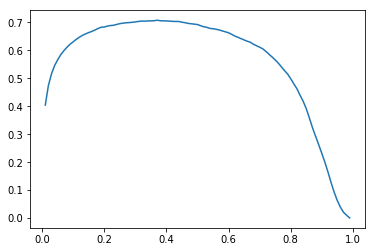

In [17]:
curve.plot()

In [18]:
submission_df = pd.read_csv('../input/sample_submission.csv')
submission_df['prediction'] = (ensemble_test_s.loc[submission_df.qid] >= thresh).astype(int).values
submission_df.to_csv('submission.csv', index=False)
submission_df.prediction.mean()

0.06785524215007983